In [1]:
import sys
sys.path.append("../")

In [7]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

In [9]:
!pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.2/27.2 MB 13.7 MB/s eta 0:00:000:00:010:00:01:01


In [22]:
cat_df = pd.read_parquet('Downloads/categories.parquet')

In [23]:
cat_df

,id,parent_id,name
0,12782,NaN,ROOT
1,12016,12782.0,Детские товары
2,12021,12457.0,Карты памяти
3,12042,13626.0,Кухонные принадлежности
4,12079,12065.0,Бутылочки и соски
...,...,...,...
7741,7796233,14030.0,Одеяла из холлофайбера
7742,7899672,12953.0,Товары для детейлинга
7743,8055966,728229.0,Купальники и пляжная одежда
7744,8094151,12643.0,Мотопомпы для грязной воды


In [29]:
cat_df = cat_df.rename(columns = {'id': 'Target', 'parent_id': 'Source', 'name': 'Label'})

In [30]:
cat_df.to_csv('Downloads/categories.csv', index=False)

In [28]:
cat_df

,Target,Source,name
0,12782,NaN,ROOT
1,12016,12782.0,Детские товары
2,12021,12457.0,Карты памяти
3,12042,13626.0,Кухонные принадлежности
4,12079,12065.0,Бутылочки и соски
...,...,...,...
7741,7796233,14030.0,Одеяла из холлофайбера
7742,7899672,12953.0,Товары для детейлинга
7743,8055966,728229.0,Купальники и пляжная одежда
7744,8094151,12643.0,Мотопомпы для грязной воды


### Stats and campaigns loading separately

In [3]:
stats = pd.read_csv('../data/vcg/stats.csv')
campaigns = pd.read_csv('../data/vcg/campaigns.csv')

In [4]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23862060 entries, 0 to 23862059
Data columns (total 11 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   item_id                   int64  
 1   campaign_id               int64  
 2   period                    float64
 3   contact_price_bin         int64  
 4   AuctionVisibilitySurplus  float64
 5   AuctionClicksSurplus      float64
 6   AuctionContactsSurplus    float64
 7   AuctionWinBidSurplus      float64
 8   CTRPredicts               float64
 9   CRPredicts                float64
 10  AuctionCount              float64
dtypes: float64(8), int64(3)
memory usage: 2.0 GB


In [5]:
def process_data(campaigns, stats):
    # Filter out invalid or undesirable data points
    stats = stats[
        stats['contact_price_bin'].notna() &
        (stats['AuctionVisibilitySurplus'] > 0) &
        (stats['AuctionClicksSurplus'] > 0) &
        (stats['AuctionContactsSurplus'] > 0) &
        (stats['AuctionWinBidSurplus'] > 0) &
        (stats['CTRPredicts'] > 0) &
        (stats['CRPredicts'] > 0)
    ]

    # Aggregate stats by campaign
    cmp_stats = stats.groupby('campaign_id').agg({
        'period': ['nunique', 'max', 'min'],
        'AuctionWinBidSurplus': 'sum',
        'AuctionContactsSurplus': 'sum',
        'AuctionClicksSurplus': 'sum',
        'contact_price_bin': 'max'
    }).reset_index()

    # Rename columns for clarity
    cmp_stats.columns = ['campaign_id', 'count_periods', 'max_period', 'min_period', 
                         'max_price_vcg', 'AuctionContactsSurplus', 'max_clicks', 'max_contact_price_bin']

    # Calculate FPA max price and max contacts
    cmp_stats['max_price_fpa'] = cmp_stats['AuctionContactsSurplus'] * np.power(1.2, cmp_stats['max_contact_price_bin'])
    cmp_stats['max_contacts'] = cmp_stats['AuctionContactsSurplus']
    cmp_stats.drop('AuctionContactsSurplus', axis=1, inplace=True)

    # Calculate number of periods and check if all periods are logged
    cmp_stats['num_periods'] = ((cmp_stats['max_period'] - cmp_stats['min_period'])/3600 + 1).astype(int)
    cmp_stats['period_full'] = cmp_stats['num_periods'] == cmp_stats['count_periods']

    # Filter and process campaigns data
    campaigns = campaigns[((campaigns['campaign_end'] - campaigns['campaign_start'])/3600/24) > 0.99]
    campaigns['count_c'] = campaigns.groupby('campaign_id')['campaign_id'].transform('count')
    campaigns = campaigns[campaigns['count_c'] == 1]
    campaigns = campaigns[['campaign_id', 'campaign_end_date', 'campaign_start', 'campaign_end', 'auction_budget']]

    # Merge campaign data with stats
    cmp_stats = pd.merge(cmp_stats, campaigns, on='campaign_id', how='inner')

    # Check if logs start at campaign start
    cmp_stats['logs_at_start'] = cmp_stats['min_period'] <= cmp_stats['campaign_start']

    # Calculate various metrics and flags
    cmp_stats['expected_periods'] = ((cmp_stats['campaign_end'] - cmp_stats['campaign_start'])/3600).astype(int)
    cmp_stats['vcg_campaign_days'] = ((cmp_stats['campaign_end'] - cmp_stats['campaign_start'])/3600/24).astype(int)
    cmp_stats['periods_logged_full'] = cmp_stats['count_periods'] >= cmp_stats['expected_periods'] - 1
    cmp_stats['budget_vcg_ok'] = cmp_stats['max_price_vcg'] > cmp_stats['auction_budget']
    cmp_stats['budget_fpa_ok'] = cmp_stats['max_price_fpa'] > cmp_stats['auction_budget']
    cmp_stats['clicks_ok'] = cmp_stats['max_clicks'] > 3
    cmp_stats['contacts_ok'] = cmp_stats['max_contacts'] > 0.5
    cmp_stats['campaign>1day'] = cmp_stats['expected_periods'] > 25
    cmp_stats['campaign>=7day'] = cmp_stats['expected_periods'] > 24 * 7
    cmp_stats['logged>1day'] = cmp_stats['num_periods'] > 25
    cmp_stats['logged>2day'] = cmp_stats['num_periods'] > 49

    # Filter for tier 1 campaigns
    campaigns_tier_1 = cmp_stats[
        cmp_stats['budget_vcg_ok'] &
        cmp_stats['budget_fpa_ok'] &
        cmp_stats['clicks_ok'] &
        cmp_stats['logs_at_start']
    ]

    return cmp_stats, campaigns_tier_1

In [6]:
cmp_stats, campaigns_tier_1 = process_data(campaigns, stats)

In [7]:
ministats = stats[stats.campaign_id.isin(set(campaigns_tier_1.campaign_id))]
minicampaigns = campaigns[campaigns.campaign_id.isin(set(campaigns_tier_1.campaign_id))]

In [8]:
len(minicampaigns), len(campaigns)

(3893, 230442)

# Some statistics of the datasets

<Axes: >

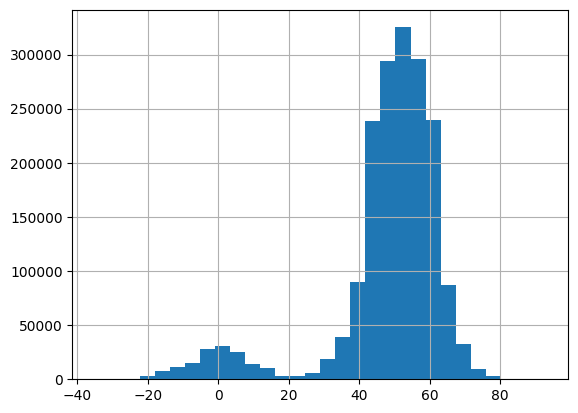

In [9]:
# Contact price bin distribution 
ministats.contact_price_bin.hist(bins=30)

In [10]:
ministats.loc[ministats.contact_price_bin < 0, 'contact_price_bin'] = -10

In [11]:
def campaigns_value_counts(campaigns: pd.DataFrame):
    length_series = pd.to_datetime(campaigns['campaign_end'], unit='s') - pd.to_datetime(campaigns['campaign_start'], unit='s')
    print(length_series.value_counts())
    pass

In [12]:
# Distribution of the lengths of the lifetime of the campaigns
campaigns_value_counts(campaigns)

1 days     177041
7 days      35109
5 days       7470
2 days       4059
3 days       3377
14 days      1276
4 days       1139
6 days        295
10 days       222
30 days        99
8 days         80
15 days        53
9 days         49
20 days        35
12 days        31
13 days        22
25 days        15
21 days        15
11 days        14
17 days         8
24 days         7
16 days         7
19 days         6
18 days         4
22 days         3
23 days         3
26 days         1
27 days         1
29 days         1
Name: count, dtype: int64


# Train + test split

In [13]:
minicampaigns.campaign_start_date.value_counts()

campaign_start_date
1986-06-18    468
1986-07-01    324
1986-06-20    315
1986-06-24    249
1986-06-23    245
1986-06-25    220
1986-06-17    219
1986-06-29    195
1986-06-16    166
1986-06-21    157
1986-06-26    149
1986-06-15    134
1986-06-19    126
1986-06-10    120
1986-06-22    113
1986-06-09    105
1986-06-11    105
1986-06-08    102
1986-06-14     89
1986-06-13     71
1986-06-12     62
1986-06-30     48
1986-06-28     46
1986-06-27     43
1986-07-02     22
Name: count, dtype: int64

In [14]:
k = len(minicampaigns) * 1 // 10
k_test = len(minicampaigns) * 2 // 10
last_train_start = max(np.partition(minicampaigns.campaign_start, k)[:k])
last_test_start = max(np.partition(minicampaigns.campaign_start, k_test)[:k_test])
print(f'length of the train: {k}, length of the test: {k_test - k}')

length of the train: 389, length of the test: 389


In [15]:
len(minicampaigns[minicampaigns.campaign_start < last_train_start]), len(minicampaigns[(minicampaigns.campaign_start >= last_train_start) & (minicampaigns.campaign_start < last_test_start)])

(388, 389)

In [18]:
# Filter out campaigns from the training set whose lifetimes intersect with any campaign in the test set
campaigns_train = minicampaigns[minicampaigns.campaign_start < last_train_start]
campaigns_test = minicampaigns[(minicampaigns.campaign_start >= last_train_start) & (minicampaigns.campaign_start < last_test_start)]

In [20]:
len(campaigns_test[campaigns_test.campaign_start > campaigns_train.campaign_end.max()])

389

In [19]:
campaigns_train = campaigns_train[campaigns_train.campaign_end < campaigns_test.campaign_start.min()]
len(campaigns_train)

79

# Saving filtered data to files

In [21]:
minicampaigns.to_csv('../data/vcg/campaigns_vcg_filtered_final.csv', index=False)
campaigns_train.to_csv('../data/vcg/campaigns_vcg_filtered_train_final.csv', index=False)
campaigns_test.to_csv('../data/vcg/campaigns_vcg_filtered_test_final.csv', index=False)

In [22]:
ministats.to_csv('../data/vcg/stats_vcg_filtered_final.csv', index=False)
ministats[ministats.campaign_id.isin(campaigns_train.campaign_id)].to_csv('../data/vcg/stats_vcg_filtered_train_final.csv', index=False)
ministats[ministats.campaign_id.isin(campaigns_test.campaign_id)].to_csv('../data/vcg/stats_vcg_filtered_test_final.csv', index=False)